In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [52]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTEENN

from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv('Master_DF.csv')
df.head()

,Application ID,Age,Gender,Marital Status (at the time of application),No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,No of times 90 DPD or worse in last 6 months,No of times 60 DPD or worse in last 6 months,No of times 30 DPD or worse in last 6 months,No of times 90 DPD or worse in last 12 months,No of times 60 DPD or worse in last 12 months,No of times 30 DPD or worse in last 12 months,Avgas CC Utilization in last 12 months,No of trades opened in last 6 months,No of trades opened in last 12 months,No of PL trades opened in last 6 months,No of PL trades opened in last 12 months,No of Inquiries in last 6 months (excluding home & auto loans),No of Inquiries in last 12 months (excluding home & auto loans),Presence of open home loan,Outstanding Balance,Total No of Trades,Presence of open auto loan,Performance Tag
0,954457215,48,F,Married,2.0,40.0,Bachelor,SAL,Rented,113,56,0,0,0,0,0,0,4.0,1.0,2,0,0,0,0,1.0,2999395.0,4,0,0.0
1,432830445,31,M,Married,4.0,55.0,Professional,SE_PROF,Rented,112,46,0,0,0,0,0,0,3.0,1.0,2,0,0,0,0,0.0,3078.0,5,0,0.0
2,941387308,32,M,Single,2.0,46.0,Bachelor,SE_PROF,Rented,104,49,0,0,0,0,0,0,7.0,0.0,0,0,0,0,0,1.0,3004972.0,2,0,0.0
3,392161677,43,M,Married,1.0,53.0,Bachelor,SE,Rented,94,53,0,0,0,0,0,0,11.0,1.0,1,0,0,0,0,1.0,3355373.0,4,1,0.0
4,182011211,35,F,Married,5.0,44.0,Professional,SAL,Rented,112,43,0,0,0,0,0,0,12.0,0.0,1,0,0,0,0,1.0,3014283.0,4,0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68536 entries, 0 to 68535
Data columns (total 29 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Application ID                                                   68536 non-null  int64  
 1   Age                                                              68536 non-null  int64  
 2   Gender                                                           68536 non-null  object 
 3   Marital Status (at the time of application)                      68536 non-null  object 
 4   No of dependents                                                 68536 non-null  float64
 5   Income                                                           68536 non-null  float64
 6   Education                                                        68536 non-null  object 
 7   Profession                              

In [31]:
df_cat = df.select_dtypes(include='object')


In [32]:
df[df_cat.columns] = df[df_cat.columns].astype('category')

In [33]:
df['Performance Tag'] = df['Performance Tag'].astype('category')

In [34]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
y_test = df_test['Performance Tag']
X_test = df_test.drop('Performance Tag', axis=1)

In [36]:
X_test.shape

(13708, 28)

In [37]:
y_train = df_train['Performance Tag']
X_train = df_train.drop('Performance Tag', axis=1)

In [38]:
X_train.shape

(54828, 28)

In [39]:
X_train = X_train.drop('Application ID', 1)


In [40]:
col = X_train.columns

In [41]:
sum(y_train)

2317.0

In [42]:
len(y_train)

54828

In [45]:
model = XGBClassifier(tree_method='hist', enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [46]:
y_pred = model.predict(X_test[col])

In [47]:
metrics.confusion_matrix(y_test, y_pred)

array([[13130,     4],
       [  574,     0]], dtype=int64)

In [59]:
sm = SMOTENC(categorical_features=list(df_cat.columns), random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [61]:
X_train_sm.head()

,Age,Gender,Marital Status (at the time of application),No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,No of times 90 DPD or worse in last 6 months,No of times 60 DPD or worse in last 6 months,No of times 30 DPD or worse in last 6 months,No of times 90 DPD or worse in last 12 months,No of times 60 DPD or worse in last 12 months,No of times 30 DPD or worse in last 12 months,Avgas CC Utilization in last 12 months,No of trades opened in last 6 months,No of trades opened in last 12 months,No of PL trades opened in last 6 months,No of PL trades opened in last 12 months,No of Inquiries in last 6 months (excluding home & auto loans),No of Inquiries in last 12 months (excluding home & auto loans),Presence of open home loan,Outstanding Balance,Total No of Trades,Presence of open auto loan
0,45,M,Married,1.0,49.0,Professional,SAL,Rented,6,3,0,0,0,0,0,0,10.0,2.0,5,1,1,0,2,1.0,3150603.0,7,0
1,49,M,Married,2.0,37.0,Masters,SE_PROF,Rented,120,12,0,0,0,0,0,0,5.0,1.0,5,1,3,1,1,0.0,596321.0,5,0
2,55,M,Married,1.0,23.0,Masters,SAL,Rented,101,33,0,0,0,0,1,1,11.0,0.0,0,0,0,0,0,0.0,1147.0,3,0
3,57,M,Married,5.0,4.5,Bachelor,SE_PROF,Rented,18,56,0,0,0,1,0,0,113.0,1.0,4,1,2,1,2,0.0,382682.0,5,0
4,41,M,Married,3.0,53.0,Professional,SAL,Rented,26,3,0,0,0,0,0,0,25.0,5.0,16,3,6,8,14,1.0,4030792.0,32,0


In [62]:
sum(y_train_sm)

52511.0

In [63]:
len(y_train_sm)

105022

In [65]:
model_sm = XGBClassifier(tree_method='hist', enable_categorical=True)
model_sm.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [69]:
y_pred_sm = model_sm.predict(X_test[col])

In [70]:
metrics.confusion_matrix(y_test, y_pred_sm)

array([[13105,    29],
       [  573,     1]], dtype=int64)

In [74]:
n_folds = 3

xgb = XGBClassifier(tree_method='hist', enable_categorical=True)

scorer = {
    #'accuracy': make_scorer(accuracy_score),
    #'f1': make_scorer(f1_score)
    'recall' : metrics.make_scorer(metrics.recall_score)
    }

#imba_pipeline = make_pipeline(SMOTE(random_state=100), rf)
imba_pipeline = make_pipeline(SMOTENC(categorical_features=list(df_cat.columns), random_state=42), xgb)

param = 'xgbclassifier__'

In [85]:
# specify range of hyperparameters
param_grid = {param+'subsample': [0.3, 0.6, 0.9]}          

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = imba_pipeline, 
                        param_grid = param_grid, 
                        scoring= scorer,
                        refit='recall', 
                        cv = n_folds, 
                        verbose = 1,
                        return_train_score=True)   

model_cv.fit(X_train, y_train)   


Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smotenc',
                                        SMOTENC(categorical_features=['Gender',
                                                                      'Marital '
                                                                      'Status '
                                                                      '(at the '
                                                                      'time of '
                                                                      'application)',
                                                                      'Education',
                                                                      'Profession',
                                                                      'Type of '
                                                                      'residence'],
                                                random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      ea...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'xgbclassifier__subsample': [0.3, 0.6, 0.9]},
             refit='recall', return_train_score=True,
             scoring={'recall': make_scorer(recall_score)}, verbose=1)

In [86]:
scores = pd.DataFrame(model_cv.cv_results_)
scores.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__subsample,params,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,mean_train_recall,std_train_recall
0,7.567779,0.118820,0.074797,0.000004,0.3,{'xgbclassifier__subsample': 0.3},0.015544,0.022021,0.010349,0.015971,0.004774,1,0.133333,0.125566,0.146373,0.135091,0.008585
1,6.846359,0.474853,0.085439,0.017165,0.6,{'xgbclassifier__subsample': 0.6},0.016839,0.005181,0.007762,0.009928,0.005000,2,0.146926,0.137864,0.136658,0.140483,0.004582
2,6.271896,0.040759,0.076462,0.005298,0.9,{'xgbclassifier__subsample': 0.9},0.003886,0.000000,0.003881,0.002589,0.001831,3,0.130097,0.141100,0.128886,0.133361,0.005495


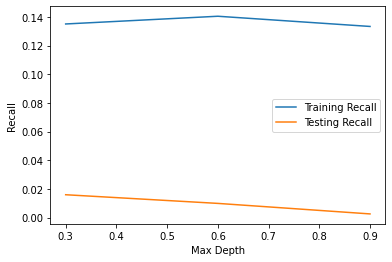

In [88]:
plt.figure()

plt.plot(scores['param_xgbclassifier__subsample'],
         scores['mean_train_recall'],
         label='Training Recall')
plt.plot(scores['param_xgbclassifier__subsample'],
         scores['mean_test_recall'],
         label='Testing Recall')

plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Recall')

plt.show()

In [77]:
y_pred_sub = model_cv.predict(X_test[col])

In [90]:
metrics.confusion_matrix(y_test, y_pred_sub)

array([[13098,    36],
       [  572,     2]], dtype=int64)